<a href="https://colab.research.google.com/github/nikadilli/elemental-imaging-enhancement/blob/master/UNetSR_test_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elemental Imaging Enhancement

**Elemental imaging** is visualization of the distribution of elements of interest within solid samples. It is widely used across different fields analyzing various materials by many analytical techniques. With destructive methods, such as LA-ICP-MS or LIBS, where the sample is ablated by laser beam spot, by spot, we get pixelated image where the resolution is dependant on the beam size. Decreasing the beam size infinitely is not possible, which leads us to other methods of image enhancement.

This notebook can be used to test a model trained on cell images that were virtualy ablated.

# Notebook setup

In [16]:
!git clone https://github.com/nikadilli/elemental-imaging-enhancement 
cd elemental-imaging-enhancement/

Cloning into 'elemental-imaging-enhancement'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 181 (delta 70), reused 131 (delta 35), pack-reused 0
Receiving objects: 100% (181/181), 10.17 MiB | 6.12 MiB/s, done.
Resolving deltas: 100% (70/70), done.


# Params and model

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn
from misc import prediction_to_image



In [0]:
width = 300 #@param {type:"number"}
height = 300 #@param {type:"number"}
path = "./test_data" #@param {type:"string"}
LR_folder = "cellsLR" #@param {type:"string"}
HR_folder = "cellsHR" #@param {type:"string"}
test_folder = "test" #@param {type:"string"}

In [0]:
size = (width, height)
path = Path(path)

In [53]:
!mkdir models
!wget https://www.dropbox.com/s/aa7fqv4sypb0ecy/model.pth -O models/m1.pth

--2019-11-20 12:27:19--  https://www.dropbox.com/s/aa7fqv4sypb0ecy/model.pth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/aa7fqv4sypb0ecy/model.pth [following]
--2019-11-20 12:27:19--  https://www.dropbox.com/s/raw/aa7fqv4sypb0ecy/model.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf119f7148d81ab1f75080ceaa8.dl.dropboxusercontent.com/cd/0/inline/AsvpNrXJewBJKHjhKMbHo0WNcQx9trnv7iWfyKlFqInf7nofC0Gc0Z7gZIBlo7ttRr7SHRvsG3hLfHTc2713P66wy5PP9Ze7xZHo5dghPBCX2VRYWbRe0a6Gx7AEiuwek7s/file# [following]
--2019-11-20 12:27:19--  https://ucf119f7148d81ab1f75080ceaa8.dl.dropboxusercontent.com/cd/0/inline/AsvpNrXJewBJKHjhKMbHo0WNcQx9trnv7iWfyKlFqInf7nofC0Gc0Z7gZIBlo7ttRr7SHRvsG3hLfHTc2713P66wy5PP9Ze7xZHo5dghPBCX2VRYWbRe0a6G

# Data preparation

In [0]:
data = (ImageImageList.from_folder(path/LR_folder).split_none()
          .label_from_func(lambda x: path/HR_folder/x.name)
          .add_test_folder(path/test_folder)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data.c = 3

In [71]:
data

ImageDataBunch;

Train: LabelList (6 items)
x: ImageImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
Path: test_data/cellsLR;

Valid: LabelList (0 items)
x: ImageImageList

y: ImageList

Path: test_data/cellsLR;

Test: LabelList (0 items)
x: ImageImageList

y: EmptyLabelList

Path: test_data/cellsLR

In [0]:
arch = models.resnet34
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)
learn.path = Path('./')
learn.load('m1');
learn.model.eval()
learn.data = data

In [58]:
fn_lr = data.train_ds.x.items[2]; fn_lr
fn_hr = data.train_ds.y.items[2]; fn_hr

PosixPath('test_data/cellsHR/B02_s1_w1.png')

In [59]:
img_lr = open_image(fn_lr)
img_lr.shape

torch.Size([3, 103, 103])

In [60]:
img_hr = open_image(fn_hr)
img_hr.shape

torch.Size([3, 512, 512])

# Prediction test data

In [0]:
p,img_pr,b = learn.predict(img_lr)

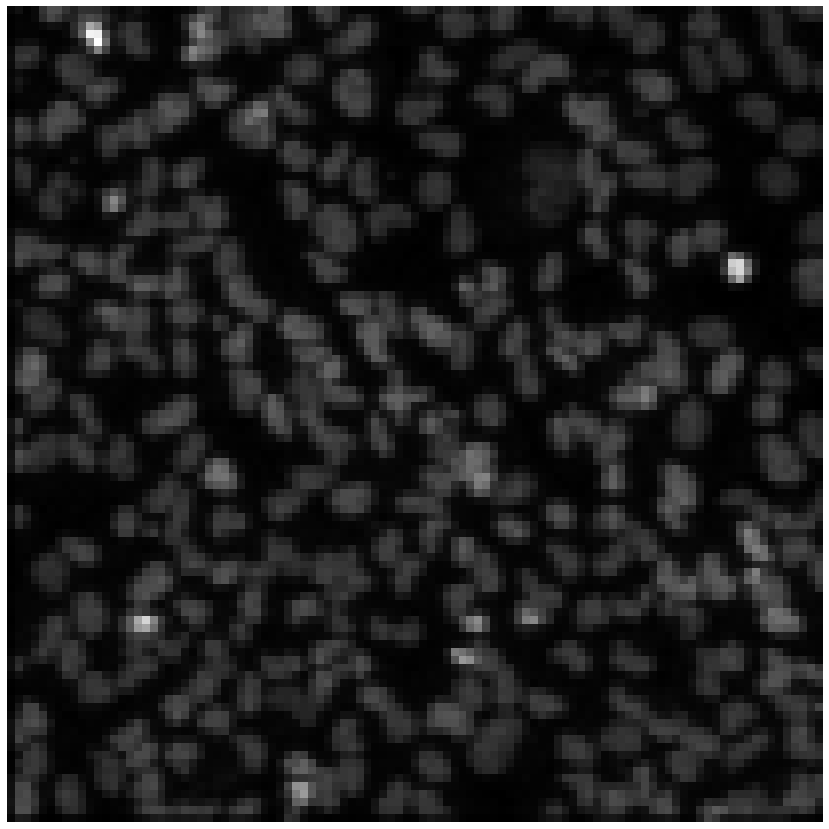

In [66]:
show_image(img_lr, figsize=(15,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


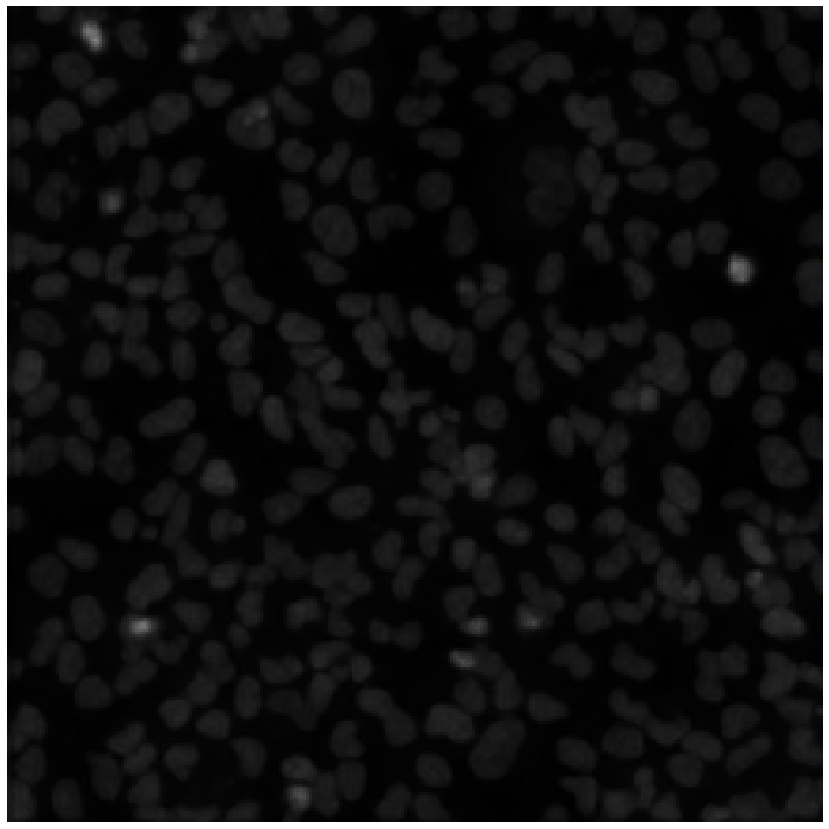

In [67]:
Image(img_pr).show(figsize=(15,15))

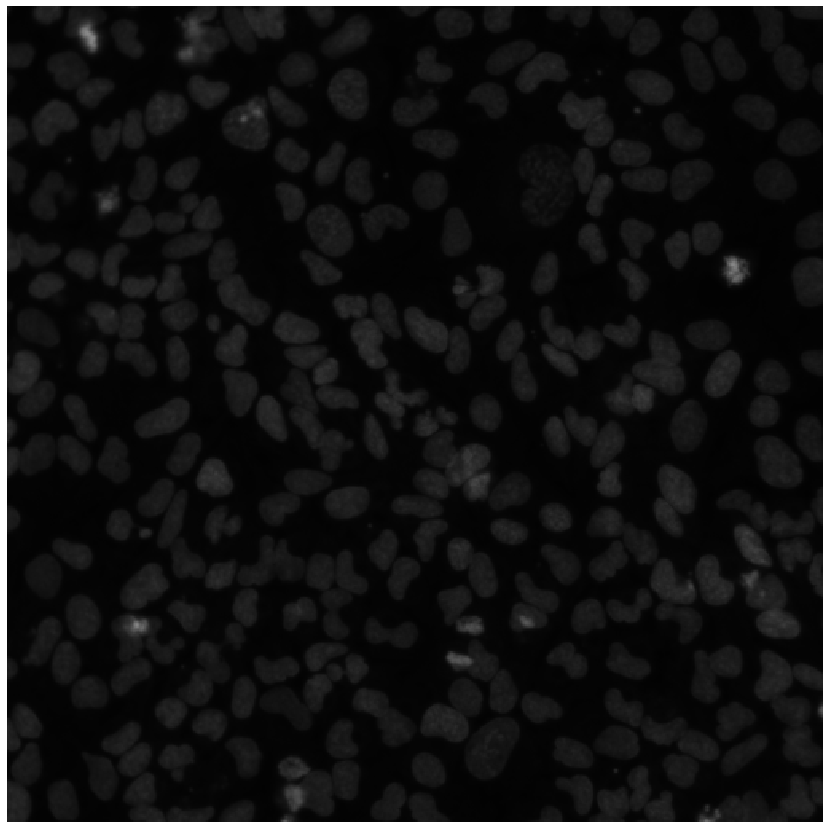

In [69]:
show_image(img_hr, figsize=(15,15), interpolation='nearest');

# Prediction on own images

This requires uploading the image into this notebook. One way to do this, is to upload the image into your google drive and mount the drive.

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')